## Mónica Villasuso López.
### Proyecto Individual - Datascience Bootcamp

## Clasificación de Lunares usando KERAS - DATA AUGMENTATION

Referencias:  
https://enmilocalfunciona.io/tratamiento-de-imagenes-usando-imagedatagenerator-en-keras/
https://datasmarts.net/es/como-usar-imagedatagenerator-para-entrenar-una-cnn-en-keras/
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html  
http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/convnets_aumentadas/convnets_aumentadas.html



In [1]:
# Manejo de archivos y directorios
import os
from os import listdir
from os.path import isfile, join

# Básicas (álgebra, números aleatorios, carga de datos en dataframe, visualizacion)
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
from random import shuffle

# Manejo de imágenes
import imageio
import cv2

# Guardar los modelos
import pickle
import json
import time

# Analítica Avanzada
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# Redes Neuronales 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  
from tensorflow.keras.preprocessing.image import ImageDataGenerator ,img_to_array

from tensorflow.keras.models import model_from_json  # Cargar los modelos guardados



## Antecedentes. Contexto  
=================================

## Carga de Datos  
=================================  
Debido a que se trata de un caso de Aprendizaje supervisado, los datos se encuentran bien diferenciados y almacenados en directorios separados según la categorización. Para este problema se han dividido en:  
* Malignos: Fotografías de lunares, manchas o lesiones de la piel que luego de ser estudiadas han sido diagnosticadas como * Malignas (Sospechosas) *  , es decir, con algún tipo de melanoma o condición que amerite tratamiento con un especialista  

* Benignos: Fotografías de lunares, manchas o lesiones de la piel que luego de ser estudiadas han sido diagnosticadas como * Benignas (Normales) *  sin que ameriten especial revisión médica.

In [2]:
os.chdir('/Users/purbina/Desktop/THE_BRIDGE/DS_MVL/PROYECTOS/projects/Final_Indiv_DataAug_v1/Lunares/Malignos')


In [3]:
# Prueba de Lectura de las imágenes
im = imageio.imread('m1.png')
print("Dimension Imagen Original: ", im.shape)  # numpy array
#Redimensiona la imagen a 48x48
im_r = cv2.resize(im, (48, 48) )  
print("Dimension Imagen Redimen: ",im_r.shape)

# Guarda la imagen en Blanco y Negro
imageio.imwrite('im_gray.jpg', im[:, :, 0])   
img = imageio.imread('im_gray.jpg')
print("Dimension Imagen Blanco y negro: ", img.shape)  
#Redimensiona la imagen a 48x48
img_r = cv2.resize(img, (48, 48) )  
print("Dimension Imagen ByN Redim: ", img_r.shape)

Dimension Imagen Original:  (293, 360, 4)
Dimension Imagen Redimen:  (48, 48, 4)
Dimension Imagen Blanco y negro:  (293, 360)
Dimension Imagen ByN Redim:  (48, 48)


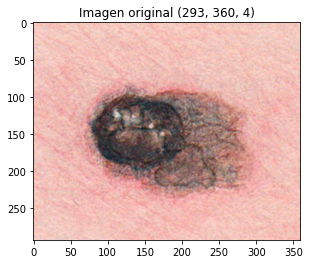

In [4]:
#Muestra la imagen leída original sin redimensionar
plt.imshow(im)
plt.title("Imagen original " + str(im.shape) )
plt.show()

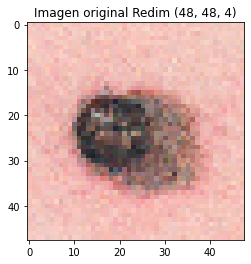

In [5]:
# La misma imagen leída despues de redimensionarse
plt.imshow(im_r)
plt.title("Imagen original Redim " + str(im_r.shape) )
plt.show()

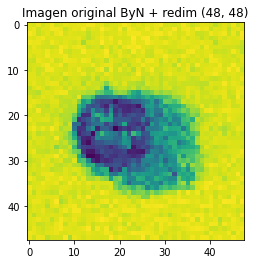

In [6]:
# La misma imagen leída despues de convertir la original  a blanco y negro y luego redimensionarse
plt.imshow(img_r)
plt.title("Imagen original ByN + redim " + str(img_r.shape) )
plt.show()

### PRUEBA DE DATA AUGMENTATION

In [9]:
augmenter = ImageDataGenerator(horizontal_flip=True,
                               rotation_range=30, 
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               zoom_range=0.2,
                               shear_range=0.1,
                               fill_mode='nearest')

In [10]:
#Prueba de Data Aumentation a una muestra de  la imagen original 
#Se convierte la imagen a array 
# el comando .flow() genera batches de la imagen transformada y las guarda en el directorio indicado
x = img_to_array(im)  # la imagen original convertida a Numpy array
x = x.reshape((1,) + x.shape)  # Numpy array con shape (1, 293,360,4)

os.chdir("/Users/purbina/Desktop/THE_BRIDGE/DS_MVL/PROYECTOS/projects/Final_Indiv_DataAug_v1/Lunares/")

i = 0
for batch in augmenter.flow(x, batch_size=1,
                          save_to_dir='DataAument', save_prefix='m_aug', save_format='png'):
    i += 1
    if i > 9:
        break  # Detiene el generador luego de 10 imágenes para que no  itere indefinidamente

### Pre-procesamiento de las imágenes

In [7]:
os.chdir('/Users/purbina/Desktop/THE_BRIDGE/DS_MVL/PROYECTOS/projects/Final_Indiv_DataAug_v1/Lunares/Benignos')
benigfiles =  [f for f in os.listdir('.') if (os.path.isfile(f)) and (not f.startswith('.'))] # excluye .DS_Store

In [8]:
len(benigfiles)

161

In [9]:
# Lee los archivos y los convierte a ByN
for elem in benigfiles:
    im = imageio.imread(elem)
    im_name = 'gray/'+ elem.split(".")[0] + 'g.jpg'
    imageio.imwrite(im_name, im[:, :, 0])  
    # Lee la imagen que acaba de convertir a ByN
    im2=imageio.imread(im_name) 
    #redimensiona a 48x48
    imageio.imwrite('gray/resize/'+ elem.split(".")[0] + 'g_r.jpg', cv2.resize(im2, (48, 48) ) ) 
    

In [13]:
os.chdir('/Users/purbina/Desktop/THE_BRIDGE/DS_MVL/PROYECTOS/projects/Final_Indiv_DataAug_v1/Lunares/Malignos')
maligfiles =  [f for f in os.listdir('.') if (os.path.isfile(f)) and (not f.startswith('.'))] # excluye .DS_Store

In [14]:
# Lee los archivos y los convierte a ByN
for elem in maligfiles:
    im = imageio.imread(elem)
    im_name = 'gray/'+ elem.split(".")[0] + 'g.jpg'
    #print (im_name)
    imageio.imwrite(im_name, im[:, :, 0])  
    # Lee la imagen que acaba de convertir a ByN
    im2=imageio.imread(im_name) 
    #redimensiona a 48x48
    imageio.imwrite('gray/resize/'+ elem.split(".")[0] + 'g_r.jpg', cv2.resize(im2, (48, 48) ) ) 

### CARGAR LAS IMÁGENES (luego de preprocesadas (i.e. Blanco y Negro y redimensionadas a 48x48))

In [15]:
tipo_lunar=[]        #Lista donde se cargaran las expresiones corresp a las fotos (0 - Maligno, 1 Benigno)

In [16]:
os.chdir('/Users/purbina/Desktop/THE_BRIDGE/DS_MVL/PROYECTOS/projects/Final_Indiv_DataAug_v1/Lunares/Benignos/gray/resize')
benigfiles_r =  [f for f in os.listdir('.') if (os.path.isfile(f)) and (not f.startswith('.'))] # excluye .DS_Store

In [17]:
# Carga las imágenes  del directorio en la lista X_data_img
X_data_img =[]
for file in benigfiles_r:
    imagen = imageio.imread(file)
    X_data_img.append(imagen)
    tipo_lunar.append(1)     #  1 = "Benigno"

In [18]:
os.chdir('/Users/purbina/Desktop/THE_BRIDGE/DS_MVL/PROYECTOS/projects/Final_Indiv_DataAug_v1/Lunares/Malignos/gray/resize')
maligfiles_r =  [f for f in os.listdir('.') if (os.path.isfile(f)) and (not f.startswith('.'))] # excluye .DS_Store

In [19]:
for file in maligfiles_r:
    imagen = imageio.imread(file)
    X_data_img.append(imagen)
    tipo_lunar.append(0)     #  0 = "Malignos"

In [20]:
# (Lista con los nombres de todas las fotos para entrenar el modelo)
allfiles = benigfiles_r + maligfiles_r
print("Imagenes: ", len(X_data_img), " - Clasif: ", len(tipo_lunar), " - Archivos: ",len(allfiles))      

Imagenes:  303  - Clasif:  303  - Archivos:  303


In [322]:
random.seed(43)
#Shuffle de las 3 listas (conservando la relacion)
mapindexpos = list(zip(X_data_img,tipo_lunar,allfiles))
random.shuffle(mapindexpos)
X_data_img,tipo_lunar,allfiles = zip(*mapindexpos)

In [323]:
# Convertir la lista a np array
X = np.squeeze(X_data_img)
X.shape

(303, 48, 48)

In [324]:
# Normalizacion de los datos
X = X.astype('float32')
X /= 255

In [325]:
# Setting del tamaño del conjunto de entrenamiento
t_size=0.85
train_size = int(len(X) * t_size)

In [326]:
# Partición del conjunto de entrenamiento y test para entrenar el modelo
(train_images, train_labels), (test_images, test_labels) = (X[:train_size],np.array(tipo_lunar[:train_size])) , (X[train_size:] , np.array(tipo_lunar[train_size:]))

In [327]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((257, 48, 48), (257,), (46, 48, 48), (46,))

In [449]:
# Nombres de las clases (target)
class_names = ['Maligno','Benigno']

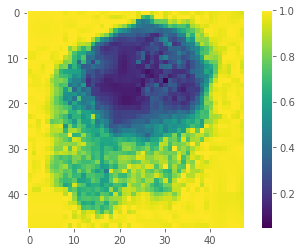

In [329]:
# Muestra primera imagen del conjunto de entrenamiento  
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [330]:
train_images.shape

(257, 48, 48)

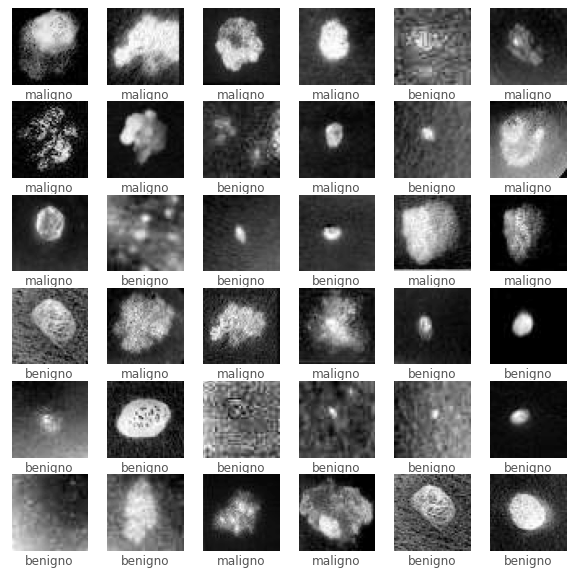

In [331]:
# Muestra las primeras 36 imagenes del conjunto de entrenamiento 
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [332]:
train_images_gr = train_images.reshape(train_images.shape[0], 48, 48, 1)
test_images_gr = test_images.reshape(test_images.shape[0], 48, 48, 1)

print("train_images_gr shape:", train_images_gr.shape)
print("test_images_gr shape:", test_images_gr.shape)

train_images_gr shape: (257, 48, 48, 1)
test_images_gr shape: (46, 48, 48, 1)


### MODELO 

EL MEJOR accuracy se alcanzó con la siguientes características:  

Settings:  
Random seed = 43  
%Train = 85%  - % Test = 15%  
% Valid = 20%
----------  
Función de activación --> RELU   (en todas las capas)  
Optimizador --> Adam  
----------  
Una CNN con:  
    - 1 capa convolutiva con 8 neuronas  
    - 1 capa convolutiva con 16 neuronas  
    - 1 MaxPool quedando las dimensiones de la imagen a la mitad  
    - 1 dropout 0.25 
    - 1 capa convolutiva con 32 neuronas  
    - 1 MaxPool quedando las dimensiones de la imagen a la mitad  
    - 1 dropout 0.25  
    - 1 Flatten  
    - 1 dense con 32 neuronas  
    - 1 dense con 64 neuronas  
    - 1 dense con 2 (Softmax --> salida)


In [333]:
tf.config.run_functions_eagerly(True)

INPUT_SHAPE = (48,48,1)

model1 = keras.models.Sequential()

# First conv-pool layers - set 1
model1.add(keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), 
activation="relu", padding="valid", input_shape=INPUT_SHAPE))
model1.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="valid"))
model1.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="valid"))
model1.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
model1.add(keras.layers.Dropout(rate=0.25))

# Flatten layer
model1.add(keras.layers.Flatten())

# Dense layers
model1.add(keras.layers.Dense(units=32, activation="relu"))
model1.add(keras.layers.Dense(units=64, activation="relu"))
# Output layer
model1.add(keras.layers.Dense(units=2, activation="softmax"))
model1.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 46, 46, 8)         80        
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 44, 44, 16)        1168      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 22, 22, 16)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 20, 20, 32)        4640      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 10, 10, 32)      

In [334]:
# Compilar el modelo
# Distintos valores probados para el optimizador (*los mejores) : (*adam, *RMSprop, AdaMax, Adadelta, Adagrad)
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [335]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta=1e-4)  
callbacks_list = [early_stop, reduce_lr] 

In [336]:
# Usaremos 20% de la data de entrenamiento para validar el desempeño de la red en cada epoch.
X_train, X_valid, y_train, y_valid = train_test_split(train_images_gr, train_labels, train_size=0.8)
 

In [337]:
augmenter = ImageDataGenerator(horizontal_flip=True,
                               rotation_range=20, 
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               zoom_range=0.2,
                               shear_range=0.1,
                               fill_mode='nearest')
 

In [338]:
history = model1.fit(augmenter.flow(X_train, y_train, batch_size=48),
                        validation_data=augmenter.flow(X_valid, y_valid, batch_size=48),
                        steps_per_epoch= len(X_train) // 48,
                        epochs=100, callbacks=callbacks_list)

Epoch 1/100
4/4 [==============================] - 1s 314ms/step - loss: 0.6946 - accuracy: 0.4635 - val_loss: 0.6923 - val_accuracy: 0.5385
Epoch 2/100
4/4 [==============================] - 1s 175ms/step - loss: 0.6921 - accuracy: 0.5260 - val_loss: 0.6915 - val_accuracy: 0.5385
Epoch 3/100
4/4 [==============================] - 1s 242ms/step - loss: 0.6904 - accuracy: 0.5104 - val_loss: 0.6888 - val_accuracy: 0.5385
Epoch 4/100
4/4 [==============================] - 1s 192ms/step - loss: 0.6823 - accuracy: 0.5287 - val_loss: 0.6864 - val_accuracy: 0.5577
Epoch 5/100
4/4 [==============================] - 1s 179ms/step - loss: 0.6724 - accuracy: 0.6178 - val_loss: 0.6836 - val_accuracy: 0.5769
Epoch 6/100
4/4 [==============================] - 1s 215ms/step - loss: 0.6608 - accuracy: 0.6815 - val_loss: 0.6726 - val_accuracy: 0.6538
Epoch 7/100
4/4 [==============================] - 1s 245ms/step - loss: 0.6297 - accuracy: 0.7325 - val_loss: 0.6732 - val_accuracy: 0.5769
Epoch 8/100
4

In [339]:
test_loss, test_acc = model1.evaluate(test_images_gr,  test_labels, verbose=2)

print('\nTest accuracy:', round(test_acc,7)*100 , "%")

2/2 - 0s - loss: 0.4917 - accuracy: 0.8261

Test accuracy: 82.60869 %


[INFO] Generando gráfico...


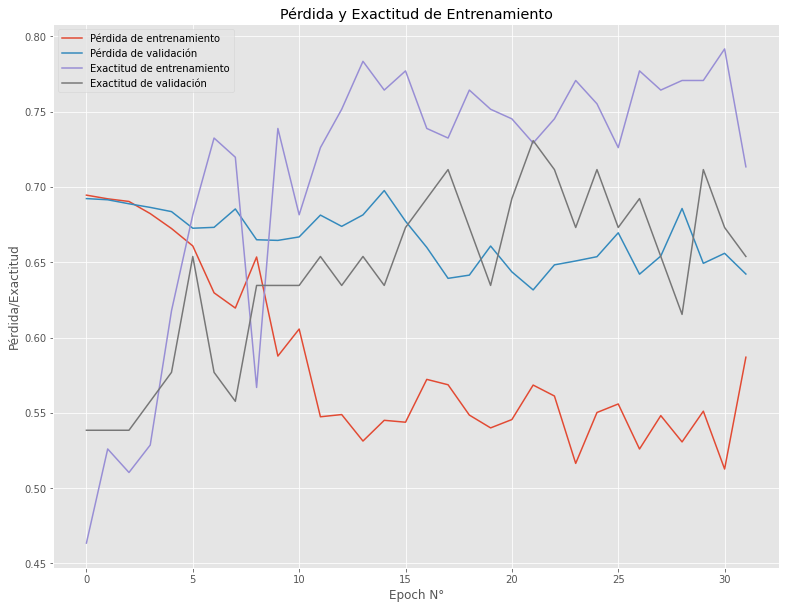

In [340]:
print('[INFO] Generando gráfico...')
plt.figure(figsize=(13,10))
plt.style.use('ggplot')
 
epoch_values = list(range(32))
plt.plot(epoch_values, history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(epoch_values, history.history['val_loss'], label='Pérdida de validación')
plt.plot(epoch_values, history.history['accuracy'], label='Exactitud de entrenamiento')
plt.plot(epoch_values, history.history['val_accuracy'], label='Exactitud de validación')
 
plt.title('Pérdida y Exactitud de Entrenamiento')
plt.xlabel('Epoch N°')
plt.ylabel('Pérdida/Exactitud')
plt.legend()

### PREDICCIONES

In [341]:
predictions = model1.predict(test_images_gr)

Pred benigno 75.22%
Pred maligno 65.54%
Pred benigno 75.27%
Pred benigno 64.6%
Pred benigno 70.55%
Pred maligno 70.07%
Pred maligno 81.01%
Pred benigno 70.41%
[0.24777795 0.75222206]
[0.65540874 0.3445913 ]
[0.24730602 0.7526941 ]
[0.35398287 0.6460172 ]
[0.2945364 0.7054636]
[0.70071596 0.299284  ]


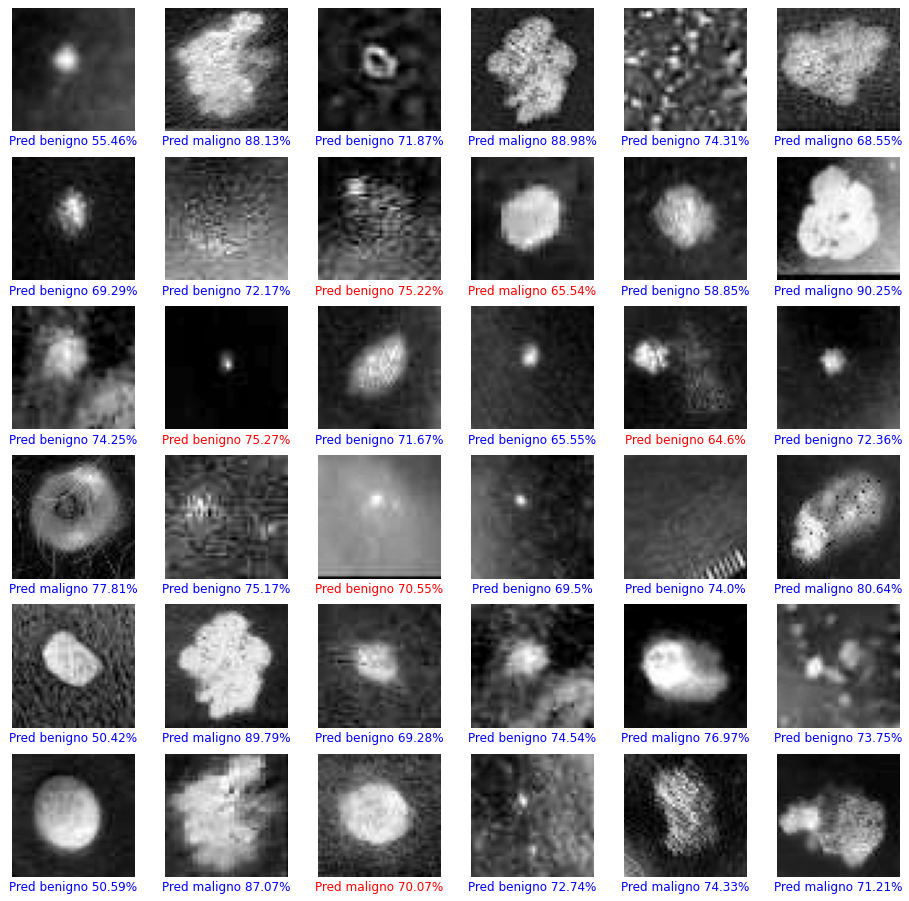

In [372]:
# VER IMAGENES DE TEST (las primeras 36) vs. (P= LO QUE PREDIJO EL MODELO )
# NOTA: (Predictions es un array de 2 posiciones con la probabilidad de que el lunar requiera revisión por especialista o que rsea benigno. Se toma la posicion de la que tenga mayor probabilidad )

# Imprime las veces donde la prediccion del conjunto de TEST es diferente al valor real
for j in range (46):
    pred_modelo = np.where(max(predictions[j])==predictions[j])[0][0]
    if class_names[test_labels[j]] !=class_names[pred_modelo]:
        print("Pred " +class_names[pred_modelo] +" " +str(round(max(predictions[j])*100,2))+ "%")

plt.figure(figsize=(16,16))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    pred_modelo = np.where(max(predictions[i])==predictions[i])[0][0]
    if class_names[test_labels[i]] ==class_names[pred_modelo]:
        col='blue'
    else:
        col='red'
    #plt.xlabel(class_names[test_labels[i]] + " (P=" +class_names[pred_modelo] +str(round(max(predictions[i])*100,2))+ "% )", color=col)
    plt.xlabel("Pred " +class_names[pred_modelo] +" " +str(round(max(predictions[i])*100,2))+ "%", color=col)
plt.show()

### Matriz de Confusión

In [443]:
predictions2 = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, predictions2))

Confusion Matrix
[[17  5]
 [ 3 21]]


### Reporte de Clasificación

In [451]:
print('Classification Report')
print(classification_report(test_labels, predictions2, target_names=class_names))

Classification Report
              precision    recall  f1-score   support

     Maligno       0.85      0.77      0.81        22
     Benigno       0.81      0.88      0.84        24

    accuracy                           0.83        46
   macro avg       0.83      0.82      0.82        46
weighted avg       0.83      0.83      0.83        46



### GUARDAR EL MODELO

In [343]:
os.chdir("/Users/purbina/Desktop/THE_BRIDGE/DS_MVL/PROYECTOS/projects/Final_Indiv_DataAug_v1/Lunares/modelos")

In [344]:
# Forma PRO de guardar los modelos  (en la carpeta modelos). Guarda el modelo y los pesos por separado. EL primer valor del nombre del archivo del modelo (test_acc)es el % de accuracy que alcanzó con el conjunto de test

moment=time.localtime()
name='Model_{}_{}-{}-{}'.format(round(test_acc,5),moment[2],moment[3],moment[4])
model1.save(name)
model_json = model1.to_json()
with open(name+'.json', "w") as json_file:
    json.dump(model_json, json_file)
model1.save_weights(name+'.h5')

INFO:tensorflow:Assets written to: Model_0.82609_16-18-16/assets


### CARGAR UN MODELO GUARDADO

In [533]:
model_name = '../modelos/Model_0.82609_16-18-16.json'
model_weigths = '../modelos/Model_0.82609_16-18-16.h5'

In [534]:
with open(model_name,'r') as f:
    model_json = json.load(f)
model3 = model_from_json(model_json)
model3.load_weights(model_weigths)

### PRUEBA CON EL MODELO GUARDADO Y CARGADO

In [535]:
os.chdir('/Users/purbina/Desktop/THE_BRIDGE/DS_MVL/PROYECTOS/projects/Final_Indiv_DataAug_v1/Lunares/Casos')

array([[188, 186, 187, ..., 204, 220, 205],
       [182, 196, 195, ..., 194, 208, 188],
       [184, 198, 198, ..., 198, 204, 204],
       ...,
       [127, 123, 101, ...,  91,  81,  90],
       [108, 104,  94, ...,  95,  89,  90],
       [115, 100, 103, ...,  91,  87,  88]], dtype=uint8)

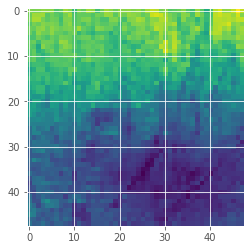

In [575]:
foto_orig=imageio.imread('f1.png')
foto_byn = foto_orig[:, :, 0]       # Foto en Blanco y Negro
foto_red=cv2.resize(foto_byn,(48,48))   # Foto reducida a 48x48
plt.imshow(foto_red)
foto_red

In [576]:

foto_normaliz=foto_red.astype('float32')    
foto_normaliz /=255             #Foto normalizada
foto_gr =foto_normaliz.reshape(1,48, 48, 1)     #Reshape para la predicción 
y_pred = model3.predict(foto_gr)
y_pred

array([[0.6634224, 0.3365776]], dtype=float32)

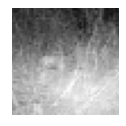

Resultado de la predicción:  MALIGNO   66.34%


In [577]:
plt.figure(figsize=(2,2))
plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.imshow(foto_normaliz,  cmap=plt.cm.binary)

#plt.imshow(test_images[0],  cmap=plt.cm.binary)
plt.show()
res_pred = class_names[np.where(max(y_pred[0])==y_pred[0])[0][0]] 
print ("Resultado de la predicción: ", res_pred.upper(), " ", str(round(max(y_pred[0])*100,2))+ "%")